# Install dependencies

In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install sklearn

pip install opencv-python

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# Get Data.
### This notebook is tested with Fashion Mnist Dataset

In [2]:
dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

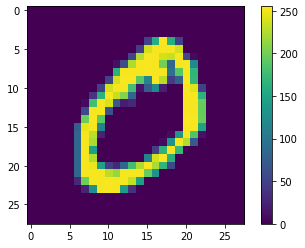

In [3]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

### Plot Data and Define classnames for the data

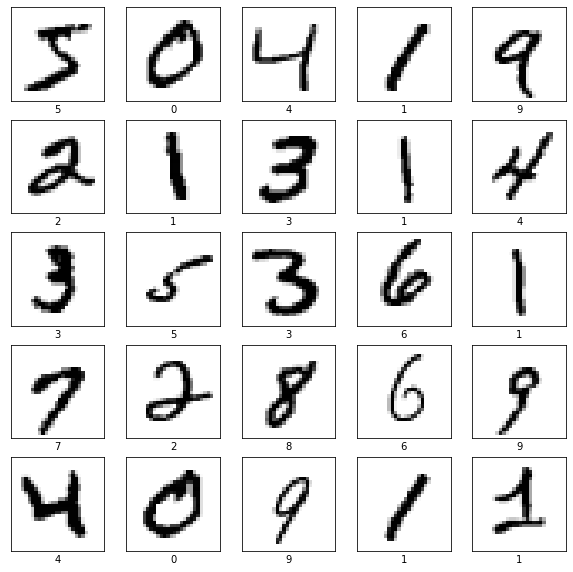

In [4]:
class_names = [0,1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Resize the Images to 28x 28 and convert them to grayscale (not required for Fashion Mnist data and Mnist data)

In [5]:
def convert_image_to_gray(image):
#     image = tf.image.grayscale_to_rgb(image)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image
    
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = dataset.load_data()
    # reshape dataset to have a single channel
    trainX = np.array([convert_image_to_gray(x) for x in trainX])
#     trainX_new = trainX.map(convert_image_to_rgb)
    testX = np.array([convert_image_to_gray(x) for x in testX])
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
#     # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train / 255.0
    test_norm = test / 255.0
    # return normalized images
    return train_norm, test_norm

### Plot the grayscale resized Images

(60000, 28, 28, 1)


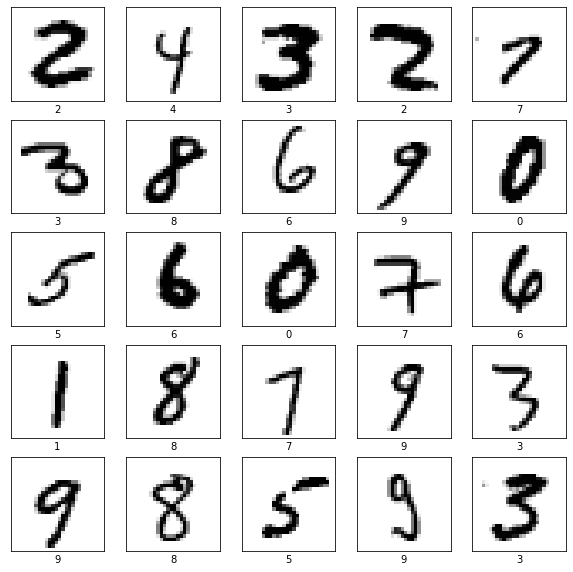

In [6]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
print(trainX.shape)
plt.figure(figsize=(10,10))
j = 0
for i in range(25,50):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
#     plt.xlabel(trainY[i])
    j = j +1
plt.show()

# Define the model

In [7]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    final_model = None
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        model.summary()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        print(history.history)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
        final_model = model
    model_name = "mnist-model.h5"
    final_model.save(model_name)
    return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()


# Train the model

In [8]:
#  run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

2021-09-04 05:46:43.017710: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


2021-09-04 05:46:43.778781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-04 05:46:43.798397: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


{'loss': [0.19263993203639984, 0.06344201415777206, 0.03946605324745178, 0.027183422818779945, 0.018953172490000725, 0.012066110037267208, 0.008451311849057674, 0.0062525044195353985, 0.0036957731936126947, 0.002662879880517721], 'accuracy': [0.9400833249092102, 0.9807708263397217, 0.9880208373069763, 0.9915000200271606, 0.9942499995231628, 0.9968125224113464, 0.9979375004768372, 0.9986249804496765, 0.9993749856948853, 0.9995833039283752], 'val_loss': [0.09053624421358109, 0.07209756225347519, 0.05872779339551926, 0.06490645557641983, 0.058081887662410736, 0.05501987785100937, 0.053030651062726974, 0.05621299892663956, 0.05791028216481209, 0.05608360841870308], 'val_accuracy': [0.9728333353996277, 0.9774166941642761, 0.9829999804496765, 0.9804999828338623, 0.984000027179718, 0.9855833053588867, 0.9860833287239075, 0.9854166507720947, 0.9861666560173035, 0.9860000014305115]}
> 98.600
Model: "sequential_1"
_________________________________________________________________
Layer (type)    

> 98.842


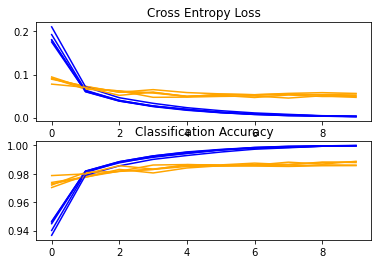

Accuracy: mean=98.732 std=0.125, n=5


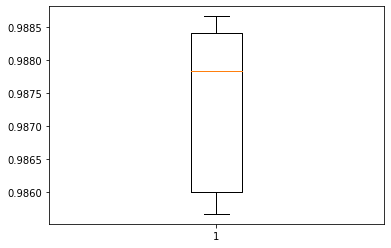

In [9]:
# entry point, run the test harness
run_test_harness()

# Load the model

In [10]:
from tensorflow.keras.models import load_model
model_name = "mnist-model.h5"
model = load_model(model_name)

In [11]:
ls .

'Cifar10 Dataset Model training using CNN with KFold Cross Validation.ipynb'
'Cifar Dataset Model training.ipynb'
 cifar-model.h5
 consumer.py
'Fashion Mnist Dataset Model training.ipynb'
'Fashion Mnist Dataset Model training using CNN with KFold Cross Validation.ipynb'
 final.h5
'Mnist Dataset Model training.ipynb'
'Mnist Dataset Model training using CNN with KFold Cross Validation-Copy1.ipynb'
 mnist-model.h5
 producer.py
 README.md


# Evaluate the model with the test images

In [12]:
# entry point, run the example
trainX, trainY, testX, testY = load_dataset()
print(trainX.shape, testX.shape)
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
predictions = model.predict(testX)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [13]:
test_loss, test_acc = model.evaluate(testX,  testY, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.0387 - accuracy: 0.9882

Test accuracy: 0.9882000088691711


# Plot the Predictions

In [14]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

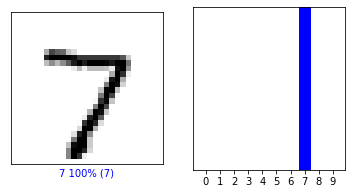

In [15]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

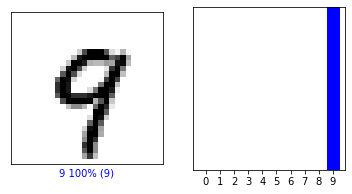

In [16]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

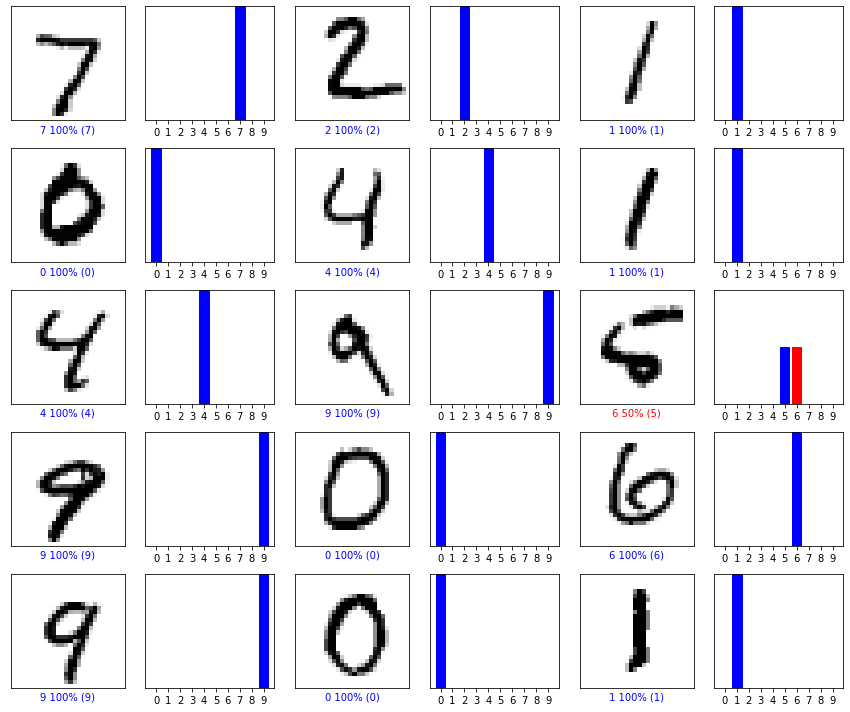

In [17]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Predict for 1 image

In [28]:
# Grab an image from the test dataset.
img = testX[1]
print(img.shape)

(28, 28, 1)


In [29]:
img = img.reshape(1, 28, 28, 1)
print(img.shape)

(1, 28, 28, 1)


In [30]:
predictions_single = model.predict(img)
print(predictions_single, np.argmax(predictions_single))

[[5.76981518e-10 3.12999418e-07 9.99999642e-01 2.44590148e-09
  1.78278638e-16 2.21048426e-13 2.89078317e-10 1.11121514e-13
  3.29803018e-10 2.08011268e-14]] 2


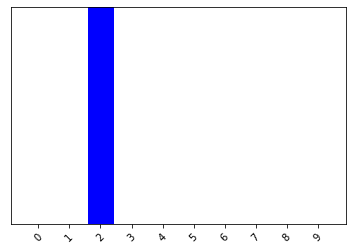

In [31]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()